In [1]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [2]:
api_base_url = 'https://api.ithacanet.tzkt.io/'
#aggregatorFactoryAddress = 'KT19K8MP6bc2MMszPZb56yihuMY19zqMxsLS' # 29 april
#aggregatorFactoryAddress = 'KT1RFV3Pz7GmfnnXAFxtwYdx3EGmnqHSBR27' # 2 may
#aggregatorFactoryAddress = 'KT1EXvLRpB3bTPBKzpmza6QYKkm2azVaLZr5' # 3 may
aggregatorFactoryAddress = 'KT1BKiVTPLnbieisakZioJH3cC2MtfgamekD' # KMS
aggregatorFactoryAddress = 'KT19NWEPVjWHF92obTVHHy9ghS9NWN27ikg2' # KMS 16 may

In [3]:
r = requests.get(api_base_url + 'v1/contracts/' + aggregatorFactoryAddress + '/storage')
storage = r.json()

storage['trackedAggregators']

trackedAggregators = list(map(lambda x:{'name': x['key']['string_0'] + '/' + x['key']['string_1'], 'address': x['value']}, storage['trackedAggregators']))

trackedAggregators

[{'name': 'USD/BTC', 'address': 'KT1PPGsBPtGFFx9t8MSkThDwJWNrczeTWfBT'},
 {'name': 'USD/DOGE', 'address': 'KT18vdDgrke5ycXofGZ8tnAVgG76xMeyaCZP'},
 {'name': 'USD/XTZ', 'address': 'KT1Vz13RJT95K6hM4RWjx2u5K8ptKt4t5rro'}]

In [4]:
# Choose aggregator

# 0 = BTC
# 1 = DOGE
# 2 = XTZ

aggregator_choice = 1

aggregator_address = trackedAggregators[aggregator_choice]['address']

print('Using aggregator ' +  trackedAggregators[aggregator_choice]['name'] + ' at ' + aggregator_address)

Using aggregator USD/DOGE at KT18vdDgrke5ycXofGZ8tnAVgG76xMeyaCZP


In [5]:
# Fetch storage history

storage_history = []
last_number_of_storage_fetched = None
max_storage_per_request=1000

while not last_number_of_storage_fetched or last_number_of_storage_fetched == max_storage_per_request:
    
    last_id = str(storage_history[-1]['id']) if len(storage_history) != 0 else None
    if last_id is not None:
        url = api_base_url + 'v1/contracts/' + aggregator_address + '/storage/history?limit=' + str(max_storage_per_request) + '&lastId=' + last_id
    else:
        url = api_base_url + 'v1/contracts/' + aggregator_address + '/storage/history?limit=' + str(max_storage_per_request)
    req = requests.get(url)
    new_storage_history = req.json()
    
    last_number_of_storage_fetched = len(new_storage_history)
    storage_history += new_storage_history

print('Fetched ' + str(len(storage_history)) + ' storages from history')

Fetched 5183 storages from history


In [6]:
# Fetch operation history

operations = []
last_number_of_operations_fetched = None
max_operations_per_request=1000

while not last_number_of_operations_fetched or last_number_of_operations_fetched == max_operations_per_request:
    
    last_id = str(operations[-1]['id']) if len(operations) != 0 else None
    if last_id is not None:
        url = api_base_url + 'v1/operations/transactions?status=applied&target=' + aggregator_address + '&limit=' + str(max_operations_per_request) + '&offset=' + str(len(operations))
    else:
        url = api_base_url + 'v1/operations/transactions?status=applied&target=' + aggregator_address + '&limit=' + str(max_operations_per_request)

    req = requests.get(url)
    new_operations_history = req.json()

    last_number_of_operations_fetched = len(new_operations_history)
    operations += new_operations_history

print('Fetched ' + str(len(operations)) + ' operations')

Fetched 5183 operations


In [7]:
# Create observations dataframe

decimals = int(storage_history[0]['value']['aggregatorConfig']['decimals'])

set_observation_operations = [op for op in operations if 'parameter' in op and op['parameter']['entrypoint'] in ['setObservationReveal']]


observations = [{
    'observation_level': int(op['level']),
    'hash': op['hash'],
    'observation_time': np.datetime64(op['timestamp']),
    'round': int(op['parameter']['value']['roundId']),
    'observation': int(op['parameter']['value']['priceSalted']['nat']) / 10 ** decimals,
    'oracle': op['sender']['address'],
    'cost': int(op['storageFee']) + int(op['bakerFee'])
 } for op in set_observation_operations]

df_observations = pd.DataFrame(data = observations)

df_observations.head()

/tmp/ipykernel_76/475992929.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  'observation_time': np.datetime64(op['timestamp']),


,observation_level,hash,observation_time,round,observation,oracle,cost
0,517857,ooKUfGoqfABNgKshzHuevckiZMnRHNbFD4ysLVrFpwRBUs...,2022-05-10 23:26:45,0,0.109079,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq,9966
1,517858,oog9tn5UgytwbdRp7cShgkxm9DUxLV93UV7XXUgYqFUAXd...,2022-05-10 23:27:05,0,0.109111,tz3Z8wLvEiauxuw4QHR4sjWNbDugB68NX8px,11969
2,519479,oojvm5GBY5HwwTTsRU6pKyhDXGo9eVSM2Y15TgSxuzWDjs...,2022-05-11 10:03:35,1,0.107708,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq,9986
3,519479,oonVwd3kDA4WDzeaX5RvKcYGiTXq2VoaA23DAvKMWvaZVL...,2022-05-11 10:03:35,1,0.107676,tz3N8cUSMpM5zknEzT7EuUCUmqYrv2A8o36P,9986
4,519480,oni3jnt1X9DKKVhTNoy3eNRMzLNSLDiWpKyqLukFWc2NLa...,2022-05-11 10:04:15,1,0.107682,tz3Z8wLvEiauxuw4QHR4sjWNbDugB68NX8px,9989


In [8]:
# Fetch balance history

oracle_addresses =  df_observations['oracle'].unique().tolist()
intresting_addresses = df_observations['oracle'].unique().tolist()
intresting_addresses.append(aggregator_address)

balances_history = []

for address in intresting_addresses:
    address_balances = []
    last_number_of_balances_fetched = None
    max_balances_per_request=1000

    while not last_number_of_balances_fetched or last_number_of_balances_fetched == max_balances_per_request:

        last_id = str(operations[-1]['id']) if len(operations) != 0 else None
        if last_id is not None:
            url = api_base_url + 'v1/accounts/' + address + '/balance_history?limit=' + str(max_balances_per_request) + '&offset=' + str(len(address_balances))
        else:
            url = api_base_url + 'v1/accounts/' + address + '/balance_history?limit=' + str(max_balances_per_request)
        req = requests.get(url)
        new_address_balances = req.json()

        last_number_of_balances_fetched = len(new_address_balances)
        balances_history += [{**x, 'address': address} for x in new_address_balances]
        address_balances += [{**x, 'address': address} for x in new_address_balances]


In [9]:
# Create request rate update (normal + deviation) dataframe

request_rate_update_storage = [x for x in storage_history if 'parameter' in x['operation'] and x['operation']['parameter']['entrypoint'] in ['requestRateUpdate', 'requestRateUpdateDeviation']]

start_of_round = [{
    'round': int(x['value']['round']),
    'start_level': x['level'],
    'start_time': np.datetime64(x['timestamp']),
    'start_hash': x['operation']['hash'],
    'previous_median': int(x['value']['lastCompletedRoundPrice']['price']) / 10 ** decimals,
    'time_round': np.datetime64(x['timestamp']),
    'deviation_round': x['operation']['parameter']['entrypoint'] == 'requestRateUpdateDeviation',
#    'start_reward_poll': sum(map(lambda y:int(y), x['value']['oracleRewardsXTZ'].values()))
 } for x in request_rate_update_storage]


end_of_round = [{
    'round': int(x['value']['round']) - 1,
    'end_level': x['level'],
    'end_time': np.datetime64(x['timestamp']),
    'end_hash': x['operation']['hash'],
    'end_reward': sum(map(lambda y:int(y), x['value']['oracleRewardsXTZ'].values())),
    'median': int(x['value']['lastCompletedRoundPrice']['price']) / 10 ** decimals if int(x['value']['round']) - 1 == int(x['value']['lastCompletedRoundPrice']['round']) else None,
    'completed': int(x['value']['round']) - 1 == int(x['value']['lastCompletedRoundPrice']['round'])
#    'end_reward_poll': sum(map(lambda y:int(y), x['value']['oracleRewardsXTZ'].values()))
 } for x in request_rate_update_storage]

#request_rate_update_storage

#df_request_rate_updates = pd.DataFrame(data = start_of_round).sort_values(by="previous_round")

#df_request_rate_updates['previous_round_deviation'] = df_request_rate_updates['previous_median'].diff() / df_request_rate_updates['previous_median'] * 100

#df_request_rate_updates
df_start_of_round = pd.DataFrame(data = start_of_round).sort_values(by="round")
df_end_of_round = pd.DataFrame(data = end_of_round).sort_values(by="round")

df_round = df_start_of_round.merge(df_end_of_round, how='inner', on='round')

df_round['deviation'] = 100 * (df_round['median'] - df_round['previous_median']) /  df_round['previous_median']
df_round.head()

/tmp/ipykernel_76/634504338.py:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  'start_time': np.datetime64(x['timestamp']),
/tmp/ipykernel_76/634504338.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  'time_round': np.datetime64(x['timestamp']),
/tmp/ipykernel_76/634504338.py:20: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  'end_time': np.datetime64(x['timestamp']),


,round,start_level,start_time,start_hash,previous_median,time_round,deviation_round,end_level,end_time,end_hash,end_reward,median,completed,deviation
0,1,519473,2022-05-11 10:00:50,op1tqZAHsiTRJokp5Sqc2KipoEEgJuzLp2TDxtKfovrteB...,0.109095,2022-05-11 10:00:50,False,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,1000,0.107682,True,-1.295192
1,2,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,0.107682,2022-05-11 10:14:25,True,519542,2022-05-11 10:25:15,ooNtsqf2MBH62SuHNDurUetjrWLQih5JPgGEVoF2GQyFUK...,1000,0.108148,True,0.432896
2,3,519542,2022-05-11 10:25:15,ooNtsqf2MBH62SuHNDurUetjrWLQih5JPgGEVoF2GQyFUK...,0.108148,2022-05-11 10:25:15,True,519557,2022-05-11 10:32:30,oo8S2WbsteKRwU2ad1fZQ2xjAuh541ypAZnHDi9wUDose6...,1000,0.107570,True,-0.534797
3,4,519557,2022-05-11 10:32:30,oo8S2WbsteKRwU2ad1fZQ2xjAuh541ypAZnHDi9wUDose6...,0.107570,2022-05-11 10:32:30,True,519565,2022-05-11 10:34:50,opUwGweEBdS1neDZzvaWV9aqwGvkUHdpyPo6iVw2qNvrig...,1000,0.107399,True,-0.158621
4,5,519565,2022-05-11 10:34:50,opUwGweEBdS1neDZzvaWV9aqwGvkUHdpyPo6iVw2qNvrig...,0.107399,2022-05-11 10:34:50,True,519578,2022-05-11 10:41:05,ontk4iwSJaHZK9ky8qD8swrZfbWJ3hRLBQ3MN691iwcg3Y...,1000,0.107195,True,-0.189946


In [10]:
# Create balances dataframe
balances_history_tmp = [{
    'level': int(b['level']),
    'time': np.datetime64(b['timestamp']),
    'balance': b['balance'] / 1_000_000,
    'address': b['address'],
 } for b in balances_history]

df_balances = pd.DataFrame(data=balances_history_tmp)

df_balances.head()

/tmp/ipykernel_76/2553285352.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  'time': np.datetime64(b['timestamp']),


,level,time,balance,address
0,516482,2022-05-10 15:44:40,200.000000,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq
1,516483,2022-05-10 15:44:55,199.947132,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq
2,517851,2022-05-10 23:23:05,199.896204,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq
3,517856,2022-05-10 23:26:15,199.886472,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq
4,517857,2022-05-10 23:26:45,199.866038,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq


In [11]:
failed_deviations_rounds = df_round.loc[df_round['deviation_round'] & (df_round['deviation'].abs() < 0.1)]
failed_deviations_rounds.head()

,round,start_level,start_time,start_hash,previous_median,time_round,deviation_round,end_level,end_time,end_hash,end_reward,median,completed,deviation
23,24,519849,2022-05-11 12:19:55,opF5nzyFcZ4JQCmcWt8mFrDdkB1fRUfTjEAWk9nY9ULqZs...,0.102778,2022-05-11 12:19:55,True,519856,2022-05-11 12:22:00,ooVWL2UvEJ2RAxbBCgz8ziHSLLVrCHgRgtfsax6KeJiCJB...,1500,0.102801,True,0.022378
28,29,519896,2022-05-11 12:37:45,ont8VkyL5VYZrEkpFk5uwRM7rfA8NKFAtiYQJKevywoo97...,0.100990,2022-05-11 12:37:45,True,519905,2022-05-11 12:42:40,opPt3KVPzUT1C2XuMpoRAn2jrSizUzUacSPQUxBpehkmrG...,1500,0.100918,True,-0.071294
40,41,519998,2022-05-11 13:20:30,oooSqNtUtLkQFqgW79oBg4xDSJsZ7CshuMb9fTCKYXUgeP...,0.090527,2022-05-11 13:20:30,True,520005,2022-05-11 13:23:15,op8iD6AG6yv9p8GGp1Zsni2KwJptrrwGq3hB21udqrBisT...,1500,0.090483,True,-0.048604
41,42,520005,2022-05-11 13:23:15,op8iD6AG6yv9p8GGp1Zsni2KwJptrrwGq3hB21udqrBisT...,0.090483,2022-05-11 13:23:15,True,520014,2022-05-11 13:26:35,oooPqLe1AhwxUw5hEYz6bHfH7SfcdRno6hfQkSwrKMNSwg...,1500,0.090483,True,0.000000
54,55,520120,2022-05-11 14:12:25,onrBRrFwBLqwmdjt5brbetGdXZ9548DcsYQfA4HiyCwoGM...,0.097430,2022-05-11 14:12:25,True,520128,2022-05-11 14:16:00,ooTjJrAnNH8ChzwJ5W5T1e1aBb7EMFTLXfK7aV2m9NNRFg...,1500,0.097442,True,0.012317


In [12]:
df_all = df_round.merge(df_observations, how='inner', on='round')
df_all.head()

,round,start_level,start_time,start_hash,previous_median,time_round,deviation_round,end_level,end_time,end_hash,end_reward,median,completed,deviation,observation_level,hash,observation_time,observation,oracle,cost
0,1,519473,2022-05-11 10:00:50,op1tqZAHsiTRJokp5Sqc2KipoEEgJuzLp2TDxtKfovrteB...,0.109095,2022-05-11 10:00:50,False,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,1000,0.107682,True,-1.295192,519479,oojvm5GBY5HwwTTsRU6pKyhDXGo9eVSM2Y15TgSxuzWDjs...,2022-05-11 10:03:35,0.107708,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq,9986
1,1,519473,2022-05-11 10:00:50,op1tqZAHsiTRJokp5Sqc2KipoEEgJuzLp2TDxtKfovrteB...,0.109095,2022-05-11 10:00:50,False,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,1000,0.107682,True,-1.295192,519479,oonVwd3kDA4WDzeaX5RvKcYGiTXq2VoaA23DAvKMWvaZVL...,2022-05-11 10:03:35,0.107676,tz3N8cUSMpM5zknEzT7EuUCUmqYrv2A8o36P,9986
2,1,519473,2022-05-11 10:00:50,op1tqZAHsiTRJokp5Sqc2KipoEEgJuzLp2TDxtKfovrteB...,0.109095,2022-05-11 10:00:50,False,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,1000,0.107682,True,-1.295192,519480,oni3jnt1X9DKKVhTNoy3eNRMzLNSLDiWpKyqLukFWc2NLa...,2022-05-11 10:04:15,0.107682,tz3Z8wLvEiauxuw4QHR4sjWNbDugB68NX8px,9989
3,2,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,0.107682,2022-05-11 10:14:25,True,519542,2022-05-11 10:25:15,ooNtsqf2MBH62SuHNDurUetjrWLQih5JPgGEVoF2GQyFUK...,1000,0.108148,True,0.432896,519514,opKNWJgoVPRW5eyXAuzRdEaWsx1hMRy5BhBeR5gpUDYocq...,2022-05-11 10:15:40,0.107798,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq,487
4,2,519509,2022-05-11 10:14:25,ooAxxTVP2WmAHaoAAznpcwAspwLoNQhsqsgDGG39q31UM3...,0.107682,2022-05-11 10:14:25,True,519542,2022-05-11 10:25:15,ooNtsqf2MBH62SuHNDurUetjrWLQih5JPgGEVoF2GQyFUK...,1000,0.108148,True,0.432896,519515,ooys46bzoUz4huAxePv4KiBKmJjECaPC4PHSR2fy6dNms3...,2022-05-11 10:16:10,0.108242,tz3Z8wLvEiauxuw4QHR4sjWNbDugB68NX8px,989


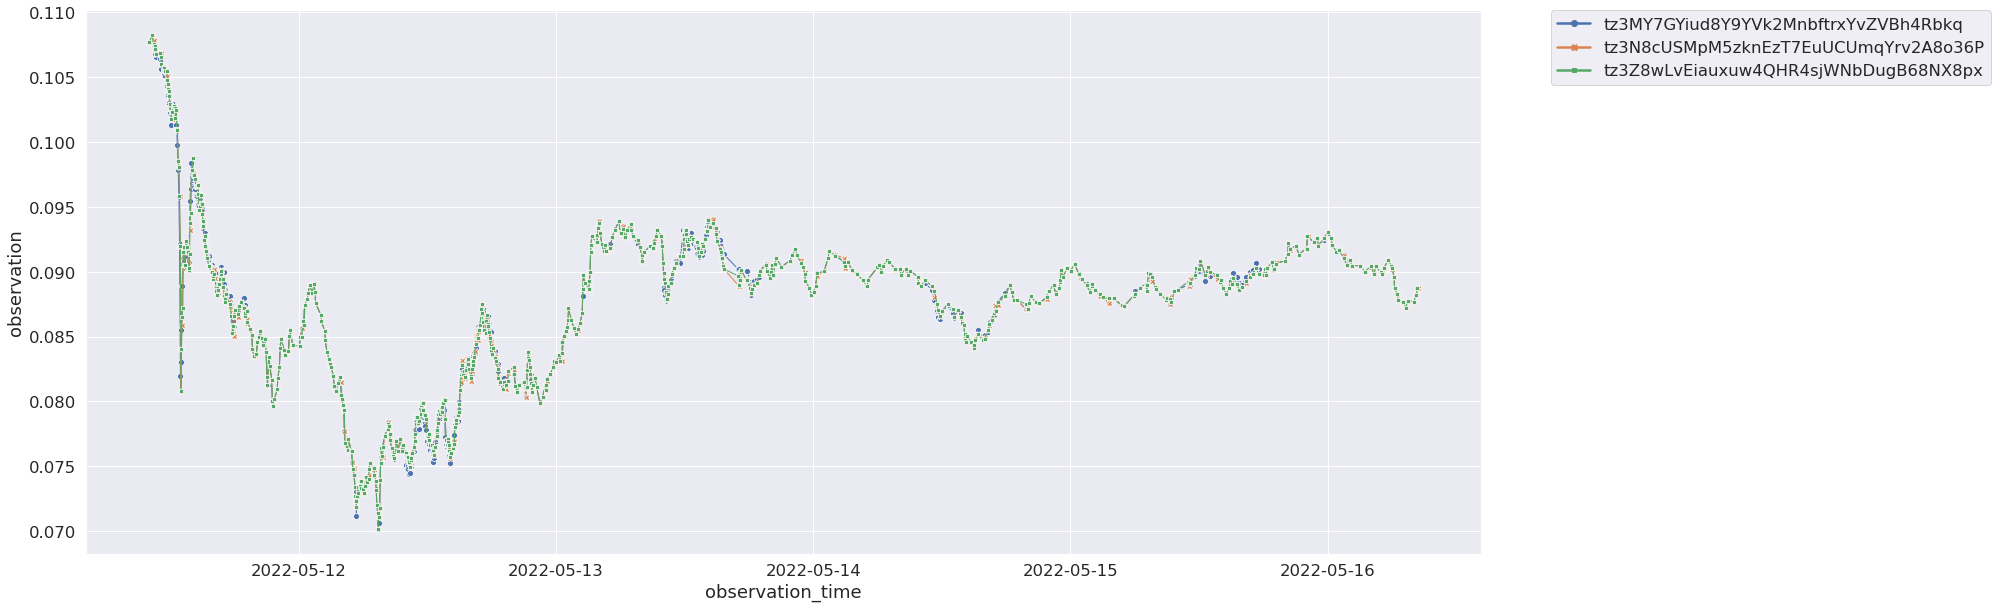

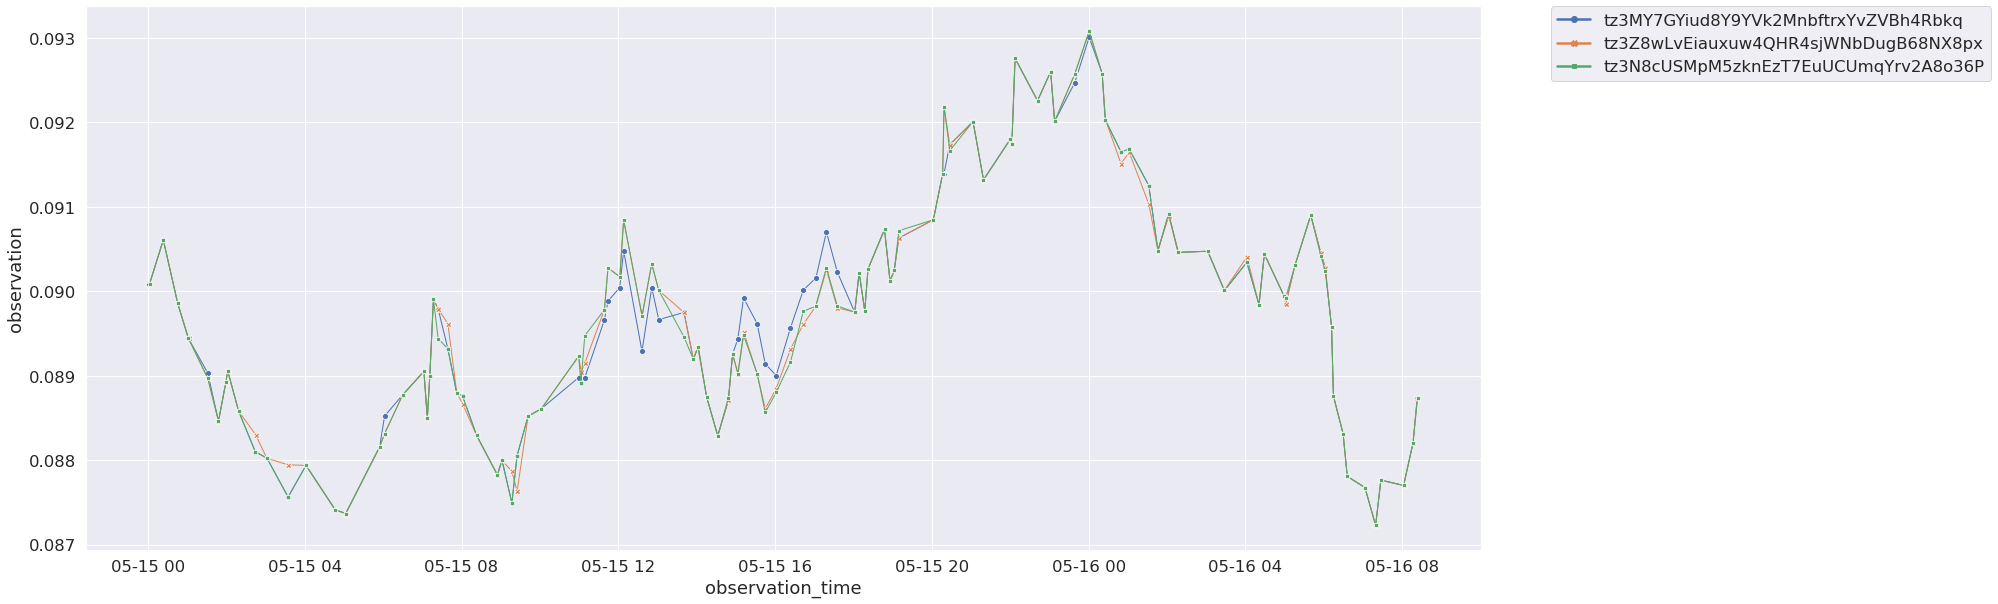

In [13]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(25, 10))

sns.lineplot(
    data=df_all, 
    x="observation_time", 
    y="observation",
    color=".7", 
    hue="oracle", 
    linewidth=1, 
    ax=ax,
    style="oracle",
    markers=True,
    dashes=False
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(25, 10))

sns.lineplot(
    data=df_all[df_all['observation_time'] > (np.datetime64(date.today() - timedelta(days=1)))], 
    x="observation_time", 
    y="observation",
    color=".7", 
    hue="oracle", 
    linewidth=1, 
    ax=ax,
    style="oracle",
    markers=True,
    dashes=False
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#sns.set_theme(style="darkgrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
#f, ax = plt.subplots(figsize=(25, 10))
#
#sns.lineplot(
#    data=df_all, 
#    x="round", 
#    y="observation",
#    color=".7", 
#    hue="oracle", 
#    linewidth=1, 
#    ax=ax,
#    style="oracle",
#    markers=True,
#    dashes=False
#)
#
#ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

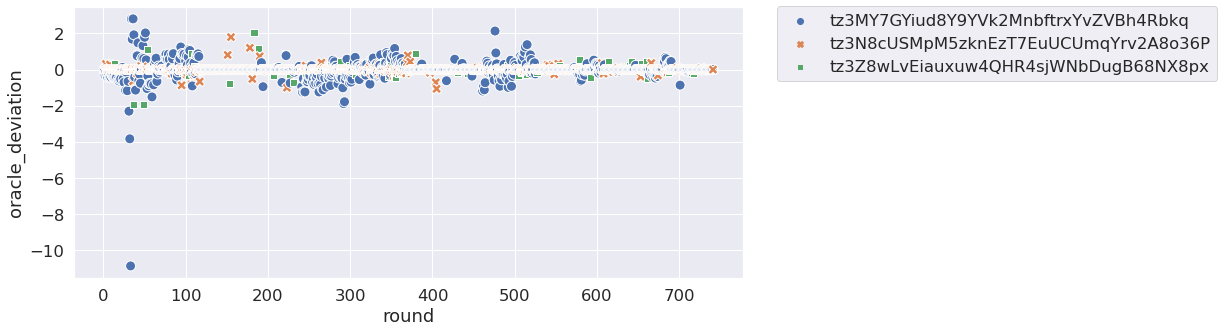

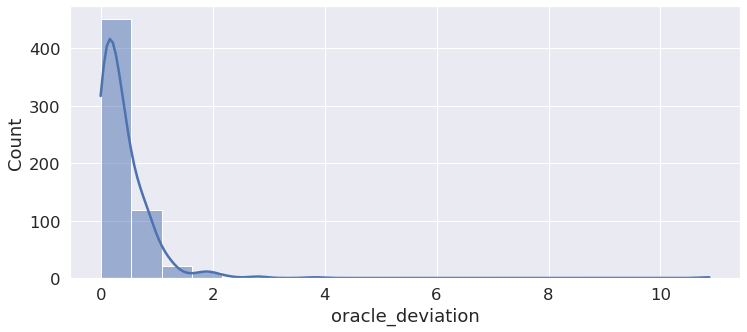

In [14]:
df_all['oracle_deviation'] = 100 * (df_all['observation'] - df_all['median']) / df_all['median']
df_all['oracle_previous_median_deviation'] = 100 * (df_all['observation'] - df_all['previous_median']) / df_all['previous_median']

sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(12, 5))

scatterplot = sns.scatterplot(
    data=df_all, 
    x="round", 
    y="oracle_deviation",
    color=".7", 
    hue="oracle", 
    linewidth=1, 
    ax=ax,
    style="oracle",
    s=100
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(12, 5))

deviation_serie = df_all['oracle_deviation'].abs()


scatterplot = sns.histplot(
    data=df_all,
    x=deviation_serie[deviation_serie != 0],
    ax=ax,
    bins=20,
    kde=True
)


[]

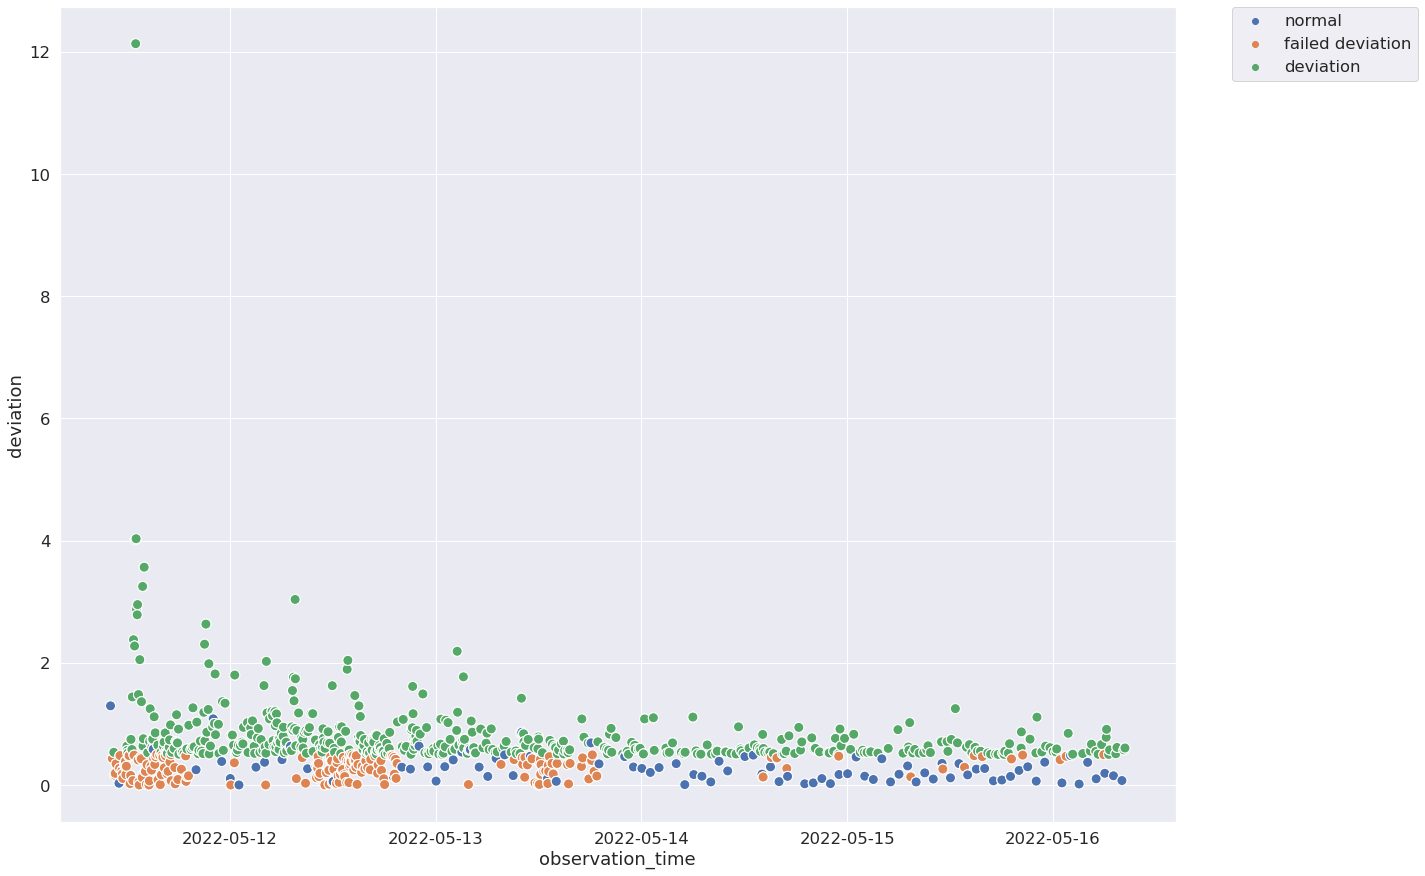

In [15]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(20, 15))

# ~df_all["deviation_round"] | (df_all["deviation_round"] & ~(df_all['deviation'].abs() < 0.5))

df_all.loc[~df_all["deviation_round"], 'round_label'] = 'normal'
df_all.loc[df_all["deviation_round"] & ~(df_all['deviation'].abs() < 0.5), 'round_label'] = 'deviation'
df_all.loc[df_all["deviation_round"] & (df_all['deviation'].abs() < 0.5), 'round_label'] = 'failed deviation'

sns.scatterplot(
    data=df_all, 
    x="observation_time", 
    y=df_all['deviation'].abs(),
    color=".7", 
    linewidth=1, 
    ax=ax,
    hue="round_label", 
    s=100
)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.plot()

In [16]:
perthousandDeviationTrigger = int(storage_history[0]['value']['aggregatorConfig']['perthousandDeviationTrigger'])

failed_deviations_rounds = df_all.loc[df_all['deviation_round'] & (df_all['deviation'].abs() < 0.1 * perthousandDeviationTrigger/2)]

col_to_display = [
    'round',
    'observation_level',
    'oracle',
    'observation',
    'oracle_previous_median_deviation',
    'median'
]
failed_deviations_rounds[col_to_display].head()

,round,observation_level,oracle,observation,oracle_previous_median_deviation,median
9,4,519562,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq,0.107029,-0.502621,0.107399
10,4,519562,tz3N8cUSMpM5zknEzT7EuUCUmqYrv2A8o36P,0.107399,-0.158621,0.107399
11,4,519563,tz3Z8wLvEiauxuw4QHR4sjWNbDugB68NX8px,0.107399,-0.158621,0.107399
12,5,519570,tz3MY7GYiud8Y9YVk2MnbftrxYvZVBh4Rbkq,0.106758,-0.596384,0.107195
13,5,519570,tz3N8cUSMpM5zknEzT7EuUCUmqYrv2A8o36P,0.107195,-0.189946,0.107195


<AxesSubplot:xlabel='deviation', ylabel='Count'>

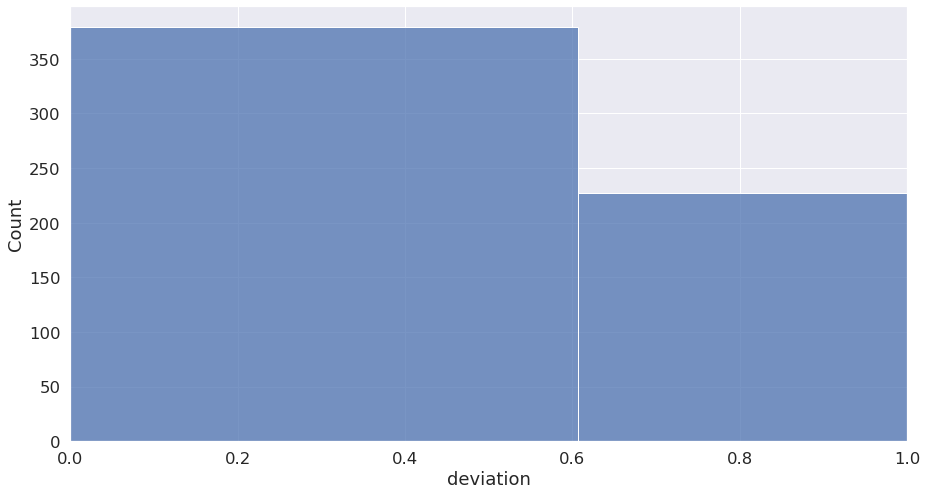

In [17]:
sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(15, 8))

ax.set_xlim(0, None)

sns.histplot(data=df_round, x=df_round[df_round['deviation_round']]['deviation'].abs(), bins=20,)

In [18]:
observation_reward_xtz = int(storage_history[0]['value']['aggregatorConfig']['rewardAmountXTZ'])
deviation_reward_xtz = 0
aggregator_start = df_all['start_time'].min()
aggregator_end = df_all['end_time'].max()
uptime = aggregator_end - aggregator_start

uptime_days = uptime.total_seconds() / (60 * 60 * 24)

n_observations = len(df_observations)
n_observations_per_day = round(n_observations / uptime_days, 2)

n_rounds = len(df_round)
n_rounds_per_day = round(n_rounds / uptime_days, 2)

n_deviation_rounds = df_round['deviation_round'].sum()
n_deviation_rounds_per_day = round(n_deviation_rounds / uptime_days, 2)


n_non_deviation_rounds = n_rounds - n_deviation_rounds
n_non_deviation_rounds_per_day = round(n_non_deviation_rounds / uptime_days, 2)


total_emited_rewards_mutez = observation_reward_xtz * n_observations + deviation_reward_xtz * n_deviation_rounds
total_emited_rewards_xtz = total_emited_rewards_mutez / 1_000_000
total_emited_rewards_xtz_per_day = round(total_emited_rewards_xtz / uptime_days, 2)
total_emited_rewards_xtz_per_month = round((total_emited_rewards_xtz / uptime_days) * 365/12, 2)

print('Reward per observation: ' + str(observation_reward_xtz) + ' mutez')
print('Aggregator uptime: ' + str(uptime))
print('')
print('Number of observations: ' + str(n_observations) + ' total (' + str(n_observations_per_day) + ' /day)')
print('Number of rounds: ' + str(n_rounds) + ' total (' + str(n_rounds_per_day) + ' /day)' )
print('Number of deviation rounds: ' + str(n_deviation_rounds) + ' total (' + str(n_deviation_rounds_per_day) + ' /day)' )
print('Number of non deviation rounds: ' + str(n_non_deviation_rounds) + ' total (' + str(n_non_deviation_rounds_per_day) + ' /day)' )
print('')
print('Upkeep cost: ' + str(total_emited_rewards_xtz) + ' XTZ total (' + str(total_emited_rewards_xtz_per_day) + ' XTZ /day) (' + str(total_emited_rewards_xtz_per_month) + ' XTZ /month)'   )



Reward per observation: 500 mutez
Aggregator uptime: 4 days 22:28:20

Number of observations: 2204 total (446.48 /day)
Number of rounds: 744 total (150.72 /day)
Number of deviation rounds: 649 total (131.47 /day)
Number of non deviation rounds: 95 total (19.25 /day)

Upkeep cost: 1.102 XTZ total (0.22 XTZ /day) (6.79 XTZ /month)


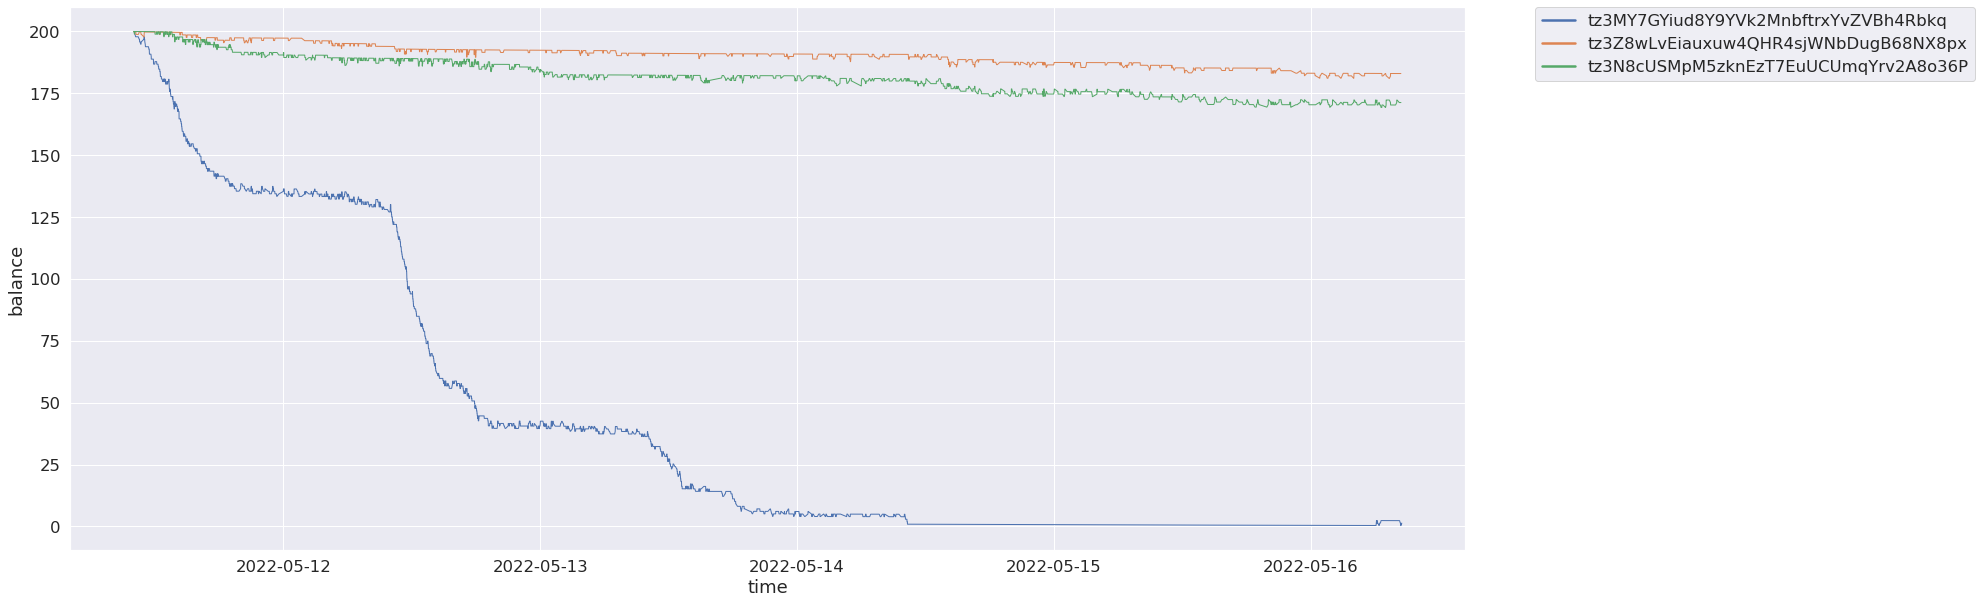

In [19]:
# Oracle balances

df_oracle_balance_only = df_balances[df_balances['address'].isin(oracle_addresses)]

aggregator_start = df_all['start_time'].min()
aggregator_end = df_all['end_time'].max()

sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(25, 10))


sns.lineplot(
    data=df_oracle_balance_only[(df_oracle_balance_only['time'] > aggregator_start) & (df_oracle_balance_only['time'] < aggregator_end)], 
    x="time", 
    y="balance",
    color=".7", 
    hue="address", 
    linewidth=1, 
    ax=ax,
    style="address",
    dashes=False
)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot:xlabel='time', ylabel='balance'>

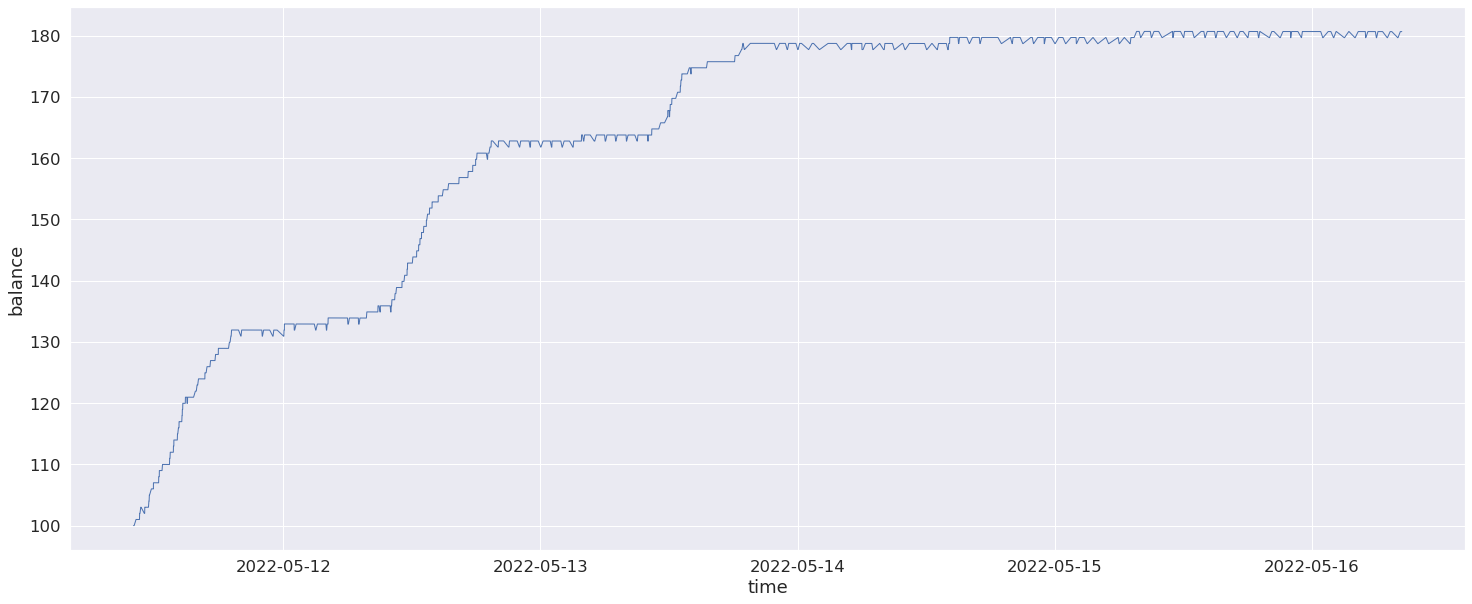

In [20]:
# Oracle balances

df_oracle_balance_only = df_balances[~df_balances['address'].isin(oracle_addresses)]

sns.set_theme(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
f, ax = plt.subplots(figsize=(25, 10))

sns.lineplot(
    data=df_oracle_balance_only[(df_oracle_balance_only['time'] > aggregator_start) & (df_oracle_balance_only['time'] < aggregator_end)], 
    x="time", 
    y="balance",
    color=".7", 
    hue="address", 
    linewidth=1, 
    ax=ax,
    style="address",
    dashes=False,
    legend=False
)